### Загрузка, исследование, подготовка временного ряда
#### Ресторан 02

In [114]:
res_name = "restaurant_02"

In [115]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import Handlers as hd

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_palette('flare')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

In [117]:
df = pd.read_csv(f"../data/{res_name}_ts.csv", index_col=0, parse_dates=[0])
df.index.freq = "D"
df

,Orders
2018-12-26,1.0
2018-12-27,NaN
2018-12-28,4.0
2018-12-29,NaN
2018-12-30,NaN
...,...
2023-07-27,384.0
2023-07-28,396.0
2023-07-29,292.0
2023-07-30,323.0


### Очистка от выбросов, выколотых точек

### Исследование выбросов в данных

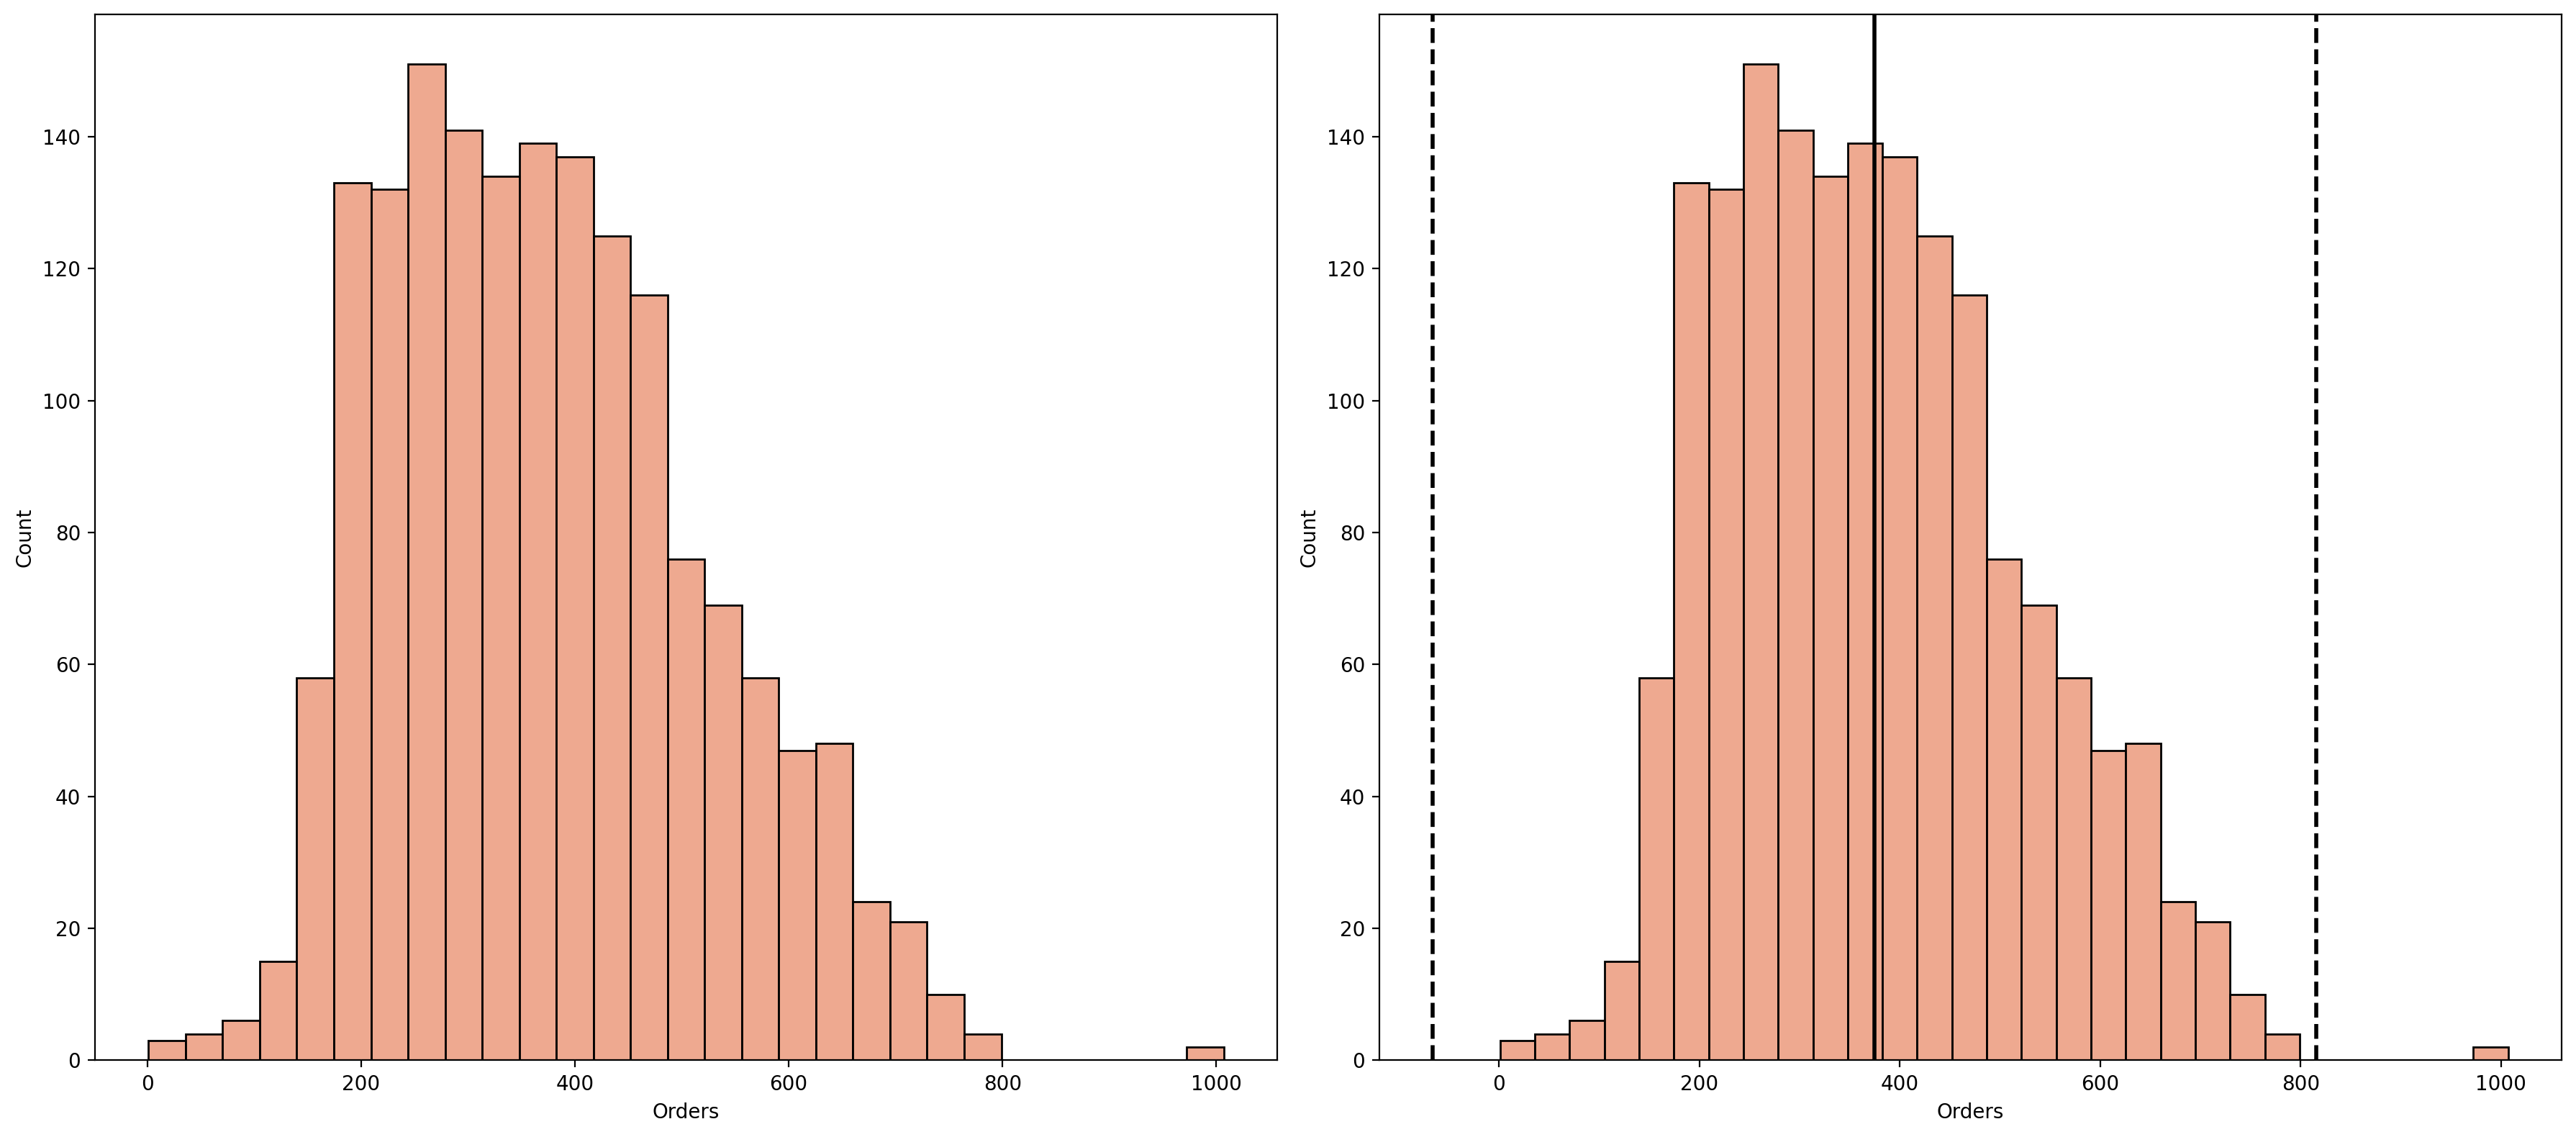

In [118]:
hd.plot_outliers_z_score(df, "Orders")

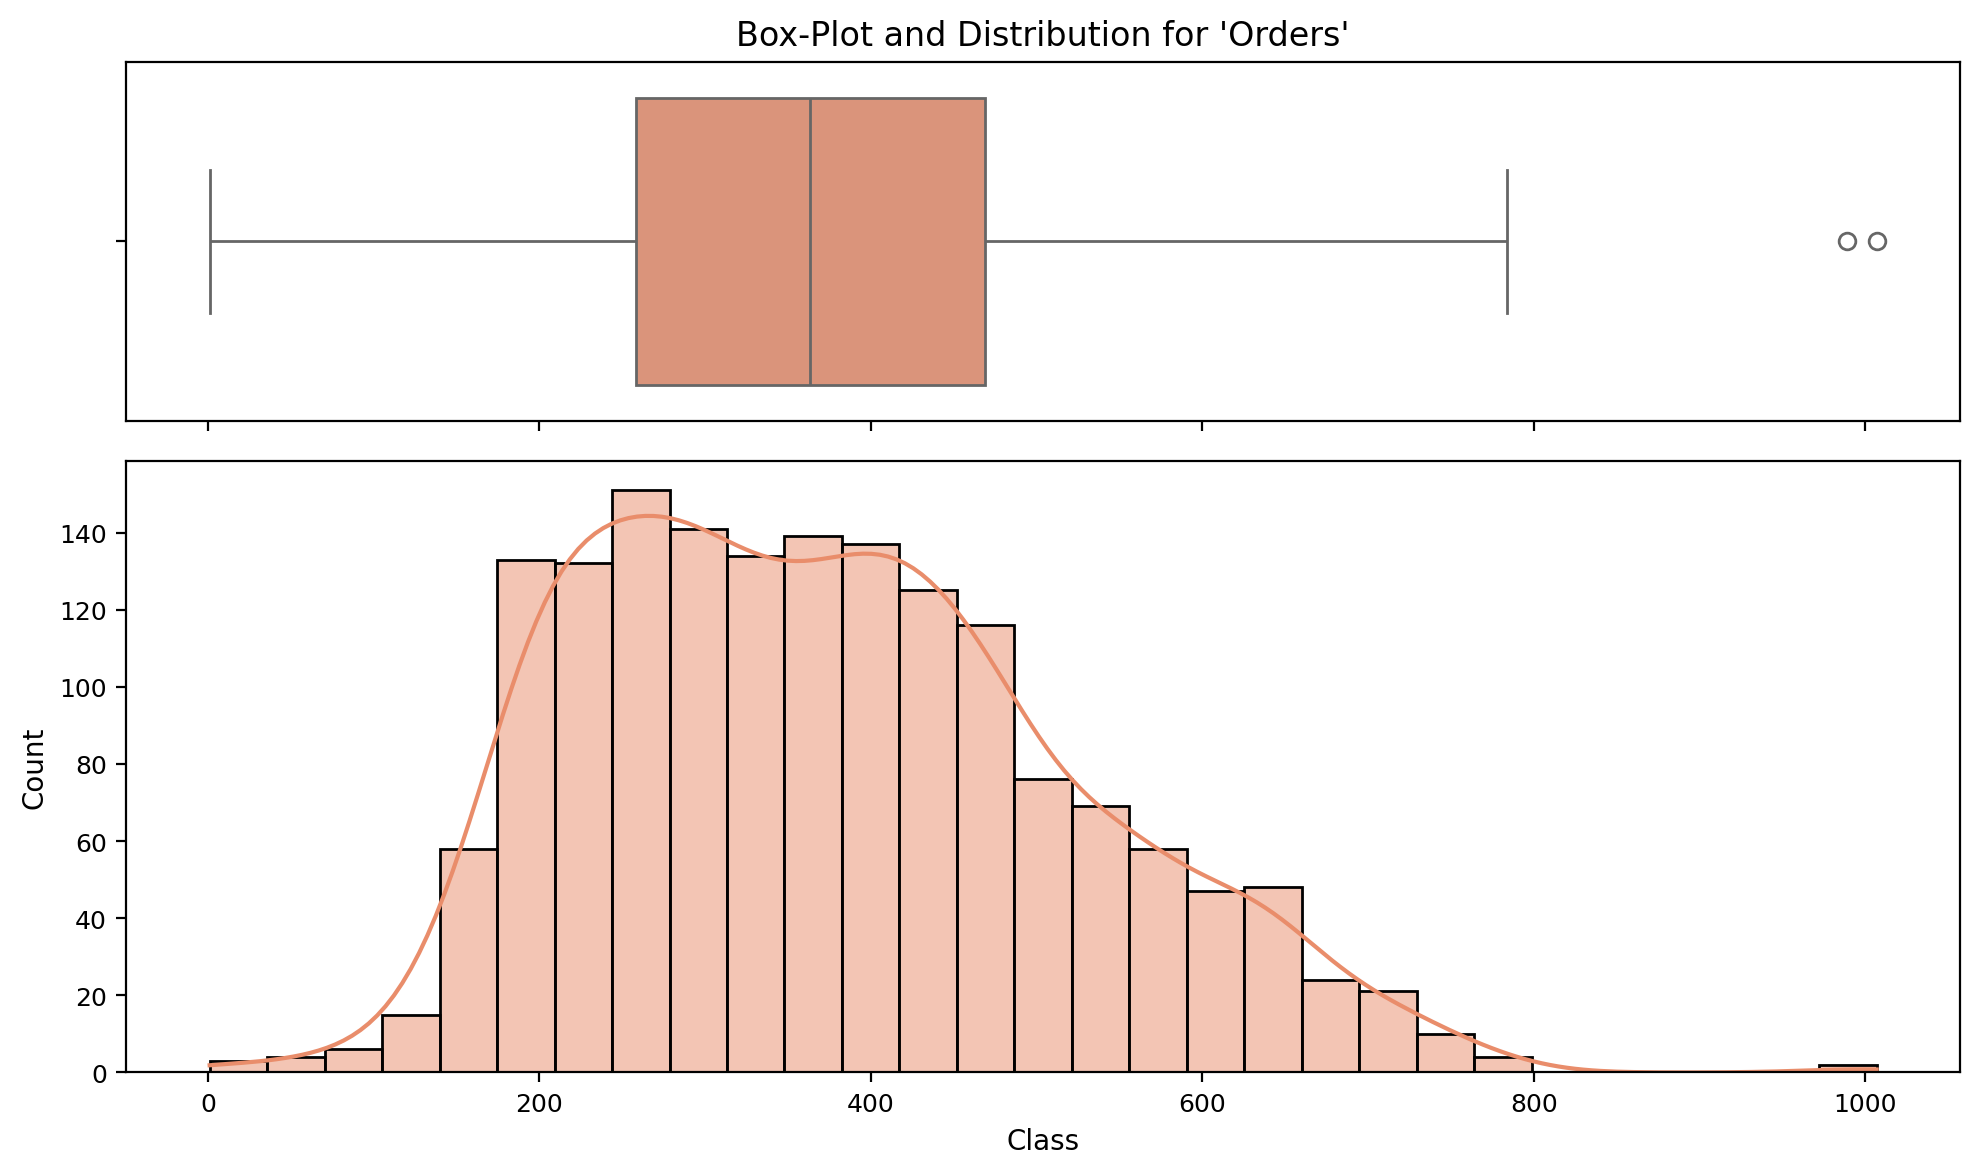

In [119]:
hd.box_and_hist_plots(df, "Orders")

Есть выбросы, изучу их

In [120]:
info, outliers, cleaned = hd.outliers_iqr(df, 'Orders')

In [121]:
info

'Outliers: 2 rows (0.12%).'

Рассмотрю все выбросы в окружении соседних дней

In [122]:
outliers

,Orders
2019-05-09,989.0
2019-09-21,1007.0


In [123]:
df[df.index >= "2019-05-07"].head(5)

,Orders
2019-05-07,643.0
2019-05-08,652.0
2019-05-09,989.0
2019-05-10,347.0
2019-05-11,650.0


9 мая, праздник, по-моему все логично что заказов сильно больше чем перед, а особенно после.

In [124]:
df[df.index >= "2019-09-19"].head(5)

,Orders
2019-09-19,617.0
2019-09-20,665.0
2019-09-21,1007.0
2019-09-22,309.0
2019-09-23,580.0


21 сентября странный день, я не вижу никаких явных событий (праздников) что бы так сильно отличалось количество заказов. Поиск выжных событий в этот день в РФ не привел к значимым результатам.

Можно считать это выбросом.

Обрабатываю через удаление и заполнение интерполяцией

In [125]:
df.loc[df.index == "2019-09-21", "Orders"] = np.nan

### Заполнение пропусков

In [126]:
# Пропущенные дни
na = df.isna().any(axis=1)
na_ind = na[na].index
na_ind

DatetimeIndex(['2018-12-27', '2018-12-29', '2018-12-30', '2018-12-31',
               '2019-01-01', '2019-09-21', '2021-01-01', '2022-01-01',
               '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24',
               '2022-04-25', '2022-04-26', '2022-04-27', '2022-04-28',
               '2022-04-29', '2022-04-30', '2022-05-01', '2022-05-02',
               '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06',
               '2023-01-01', '2023-07-15', '2023-07-16'],
              dtype='datetime64[ns]', freq=None)

In [127]:
print(f"Нет данных о заказах по {len(na_ind)} дням.")

Нет данных о заказах по 27 дням.


Заполняю пропуски линейной интерполяцией

In [128]:
df["Orders"].interpolate(method="linear", inplace=True)
# преобразую количество заказов к целому типу
df["Orders"] = df["Orders"].astype(int)

Визуализация результатов заполнения пропусков

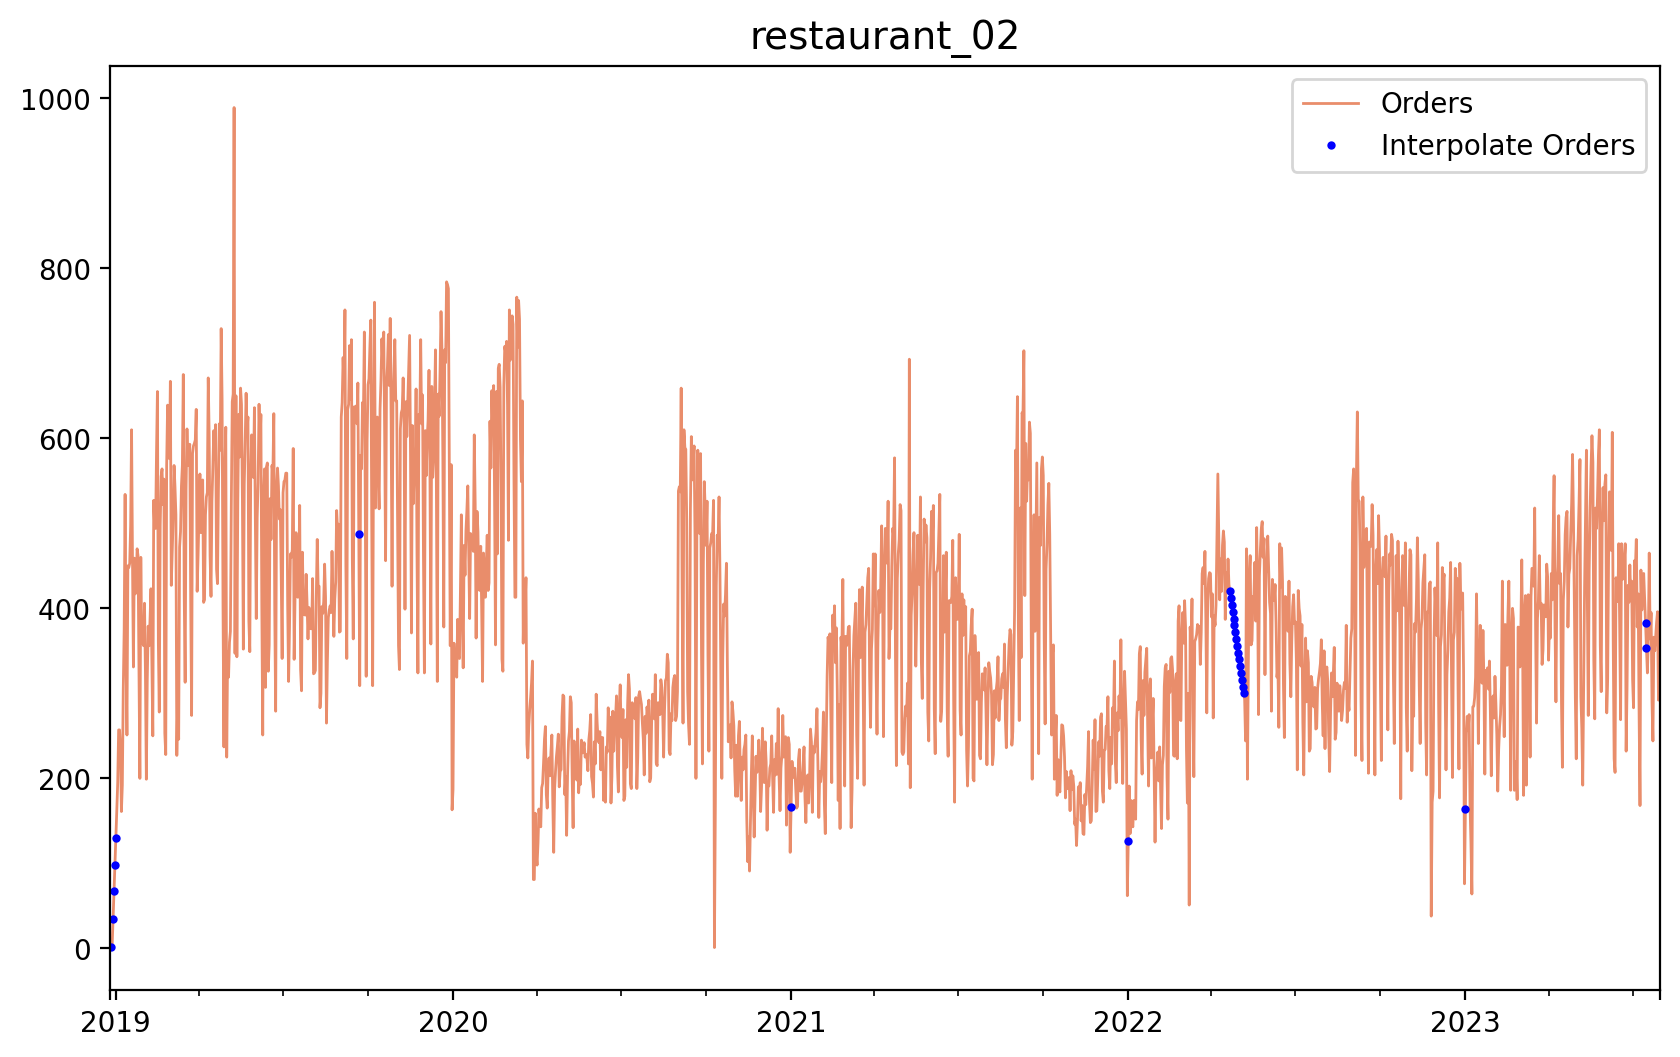

In [129]:
hd.plot_result_of_fillna(df, na_ind, res_name)

### Декомпозиция временного ряда
(тренд, сезонность внутри года, сезонность внутри недели, шум)

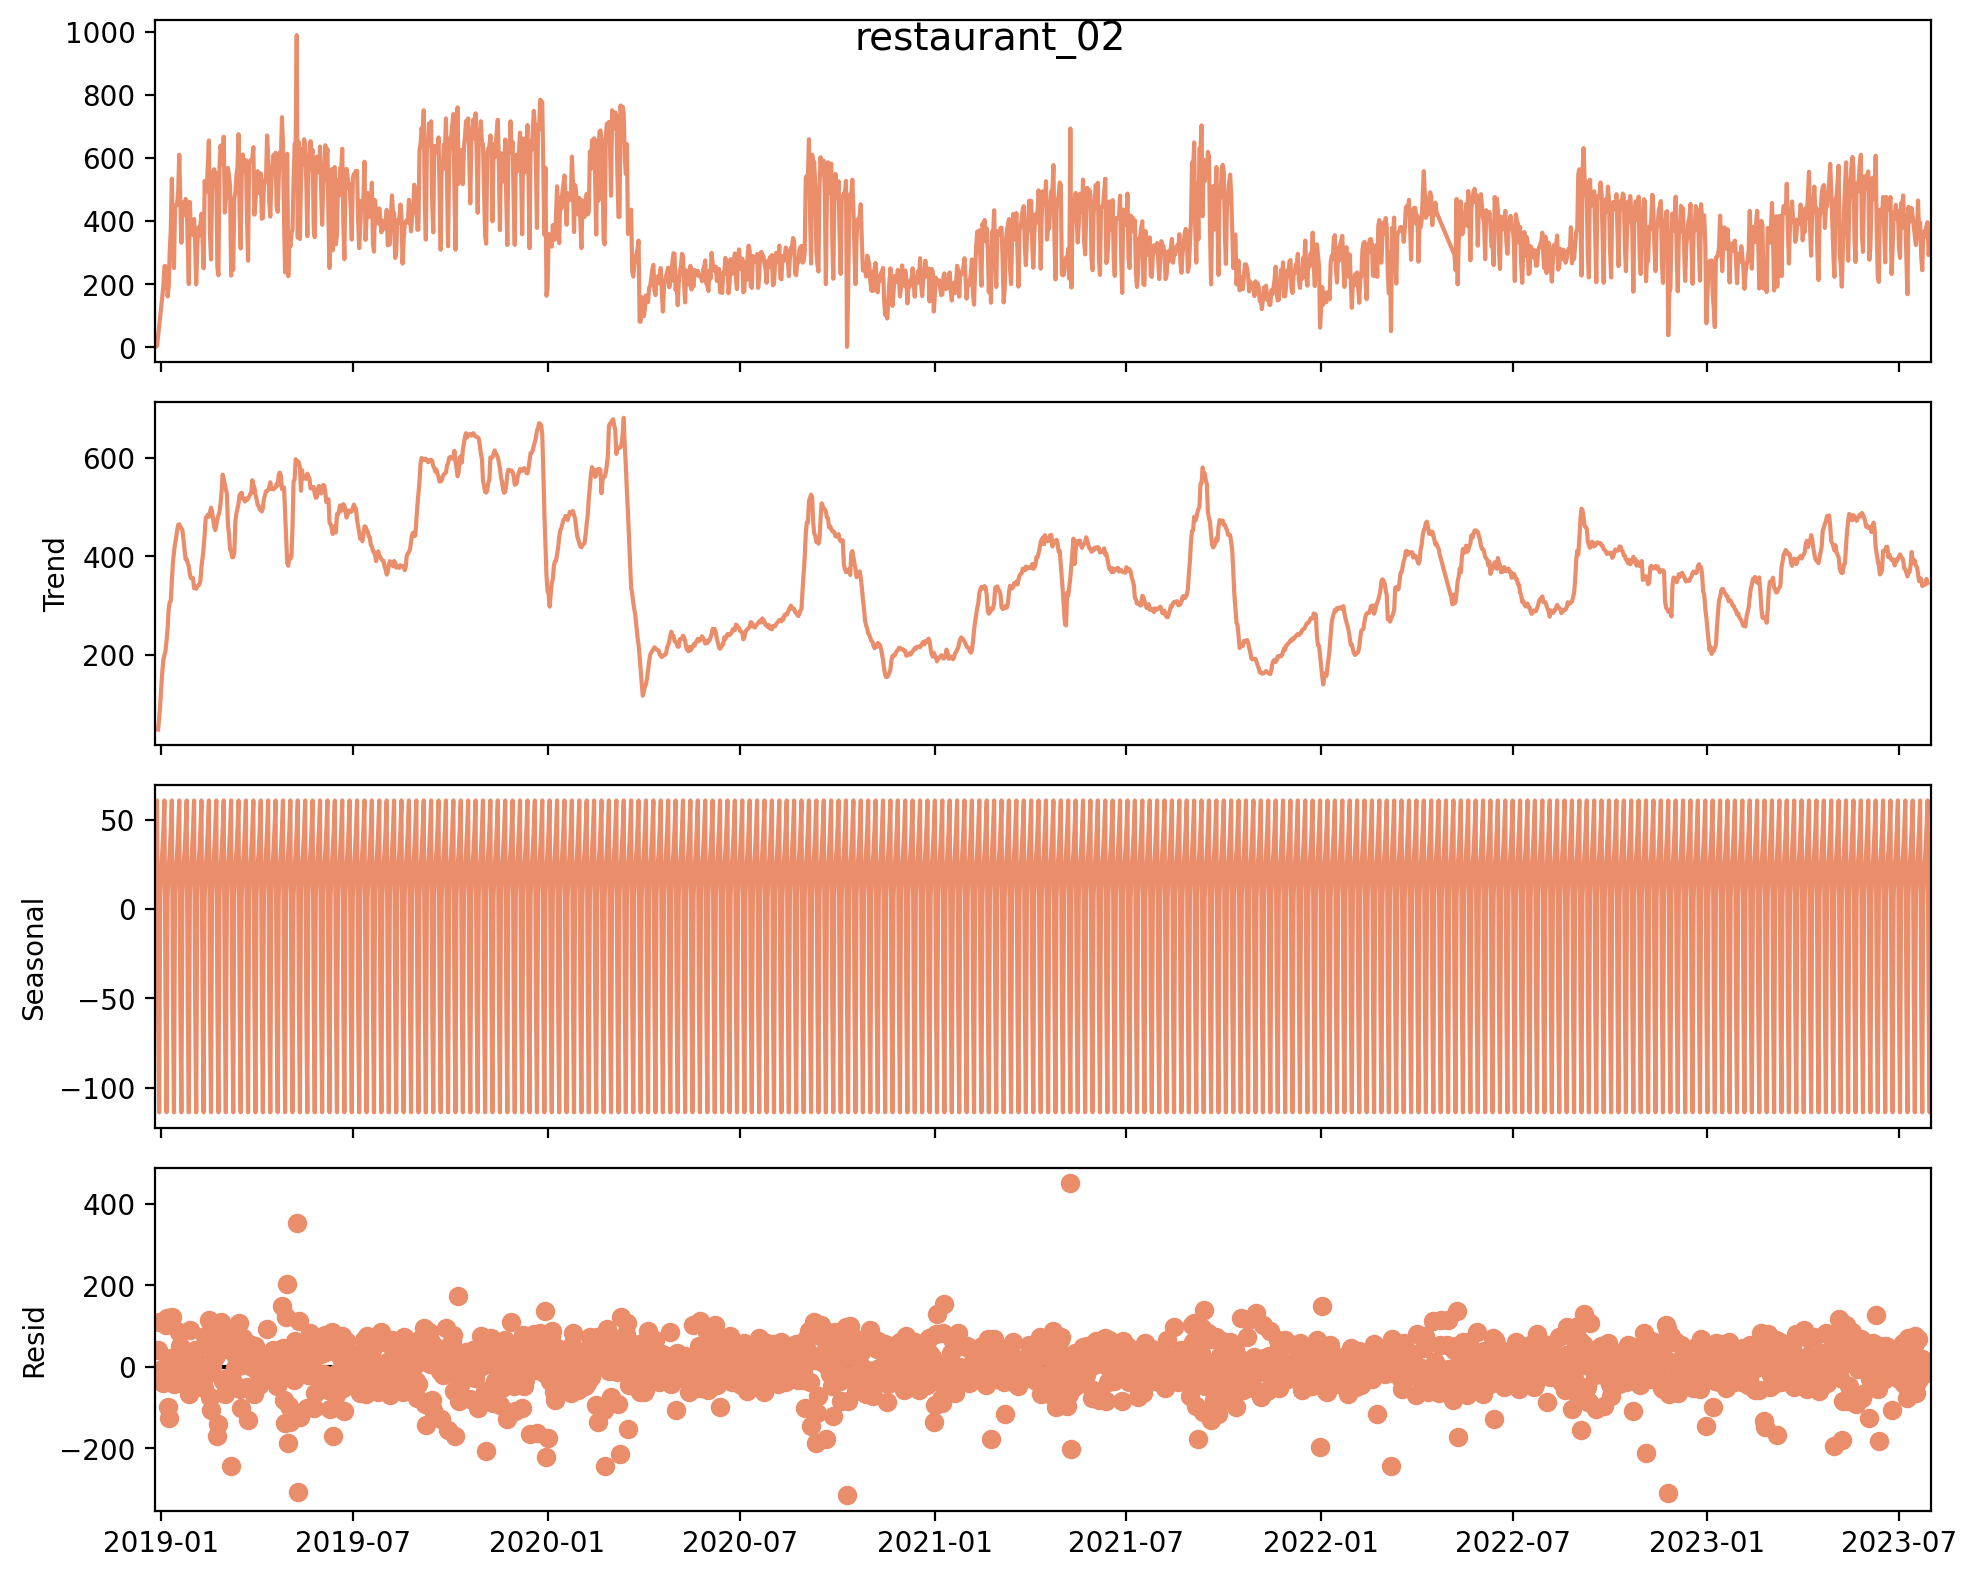

In [130]:
decomposition = seasonal_decompose(df, model="additive")
decomposition.plot()
plt.gcf().suptitle(res_name, fontsize=14)
plt.savefig("../pics/" + res_name + " decomposition.png", dpi=300, bbox_inches='tight')
plt.show()

Рассматриваю сезонную компоненту

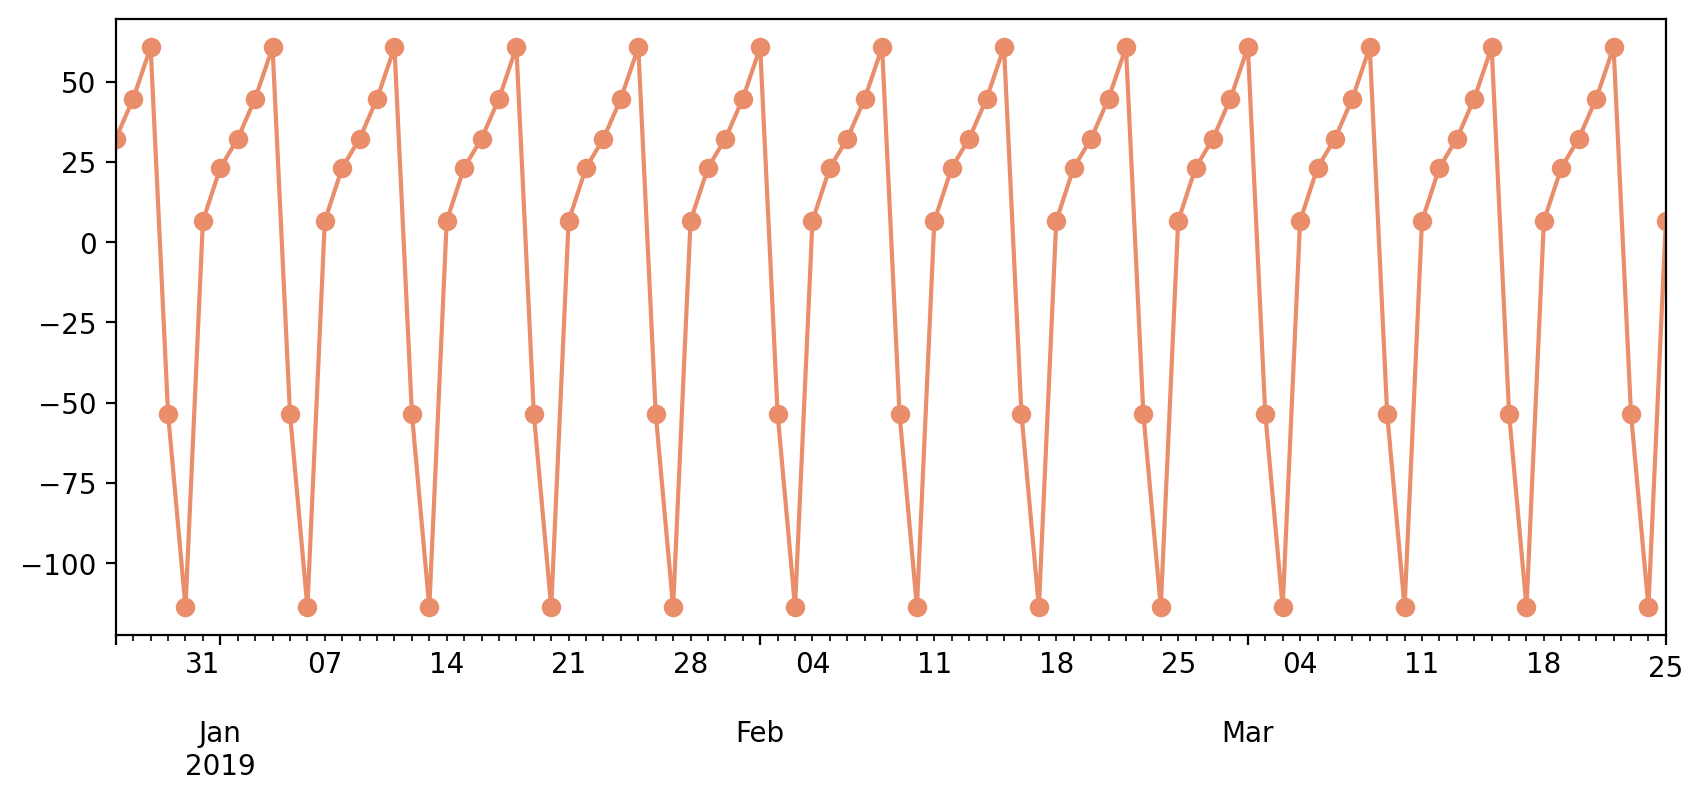

In [131]:
plt.figure(figsize=(10, 4))
decomposition.seasonal[:90].plot(marker="o")
plt.show()

График четко показывает 7 дневный (недельный) цикл сезонности.

### Прогнозирование временных рядов
- до 31.12.2023 - обязательно
- до 31.12.2024 - опционально

Определяю количество дней для будущих прогнозов

In [132]:
date1 = df.index[-1]
date2 = pd.to_datetime("2023-12-31")
date3 = pd.to_datetime("2024-12-31")

days_to_pred_2023 = (date2 - date1).days
days_to_pred_2024 = (date3 - date1).days

Использую Пророка для прогнозирования

In [133]:
# Преобразование временного ряда в необходимый пророку формат
proh_df = hd.transform_for_prophet(df)

В качестве дополнительной информации использую данные календаря

In [134]:
calendar_df = pd.read_csv("../data/calendar_ts.csv", parse_dates=["day_id"])
# Загружаю события (праздники, теплое время года, черная пятница) в датафрейм пригодный для пророка 
all_events = hd.get_events_from_calendar(calendar_df)

Предсказание до конца 2023 года

In [135]:
m = Prophet(changepoint_prior_scale=0.005, weekly_seasonality=False, holidays=all_events)
m.add_seasonality(name='custom_weekly', period=7, fourier_order=3)
m.fit(proh_df)
future = m.make_future_dataframe(periods=days_to_pred_2023, include_history=False)
forecast = m.predict(future)

pred2023 = hd.get_format_forcast(forecast)

00:58:31 - cmdstanpy - INFO - Chain [1] start processing
00:58:31 - cmdstanpy - INFO - Chain [1] done processing


Предсказание до конца 2024 года

In [136]:
m = Prophet(changepoint_prior_scale=0.005, weekly_seasonality=False, holidays=all_events)
m.add_seasonality(name='custom_weekly', period=7, fourier_order=3)
m.fit(proh_df)
future = m.make_future_dataframe(periods=days_to_pred_2024, include_history=False)
forecast = m.predict(future)

pred2024 = hd.get_format_forcast(forecast)

00:58:32 - cmdstanpy - INFO - Chain [1] start processing
00:58:33 - cmdstanpy - INFO - Chain [1] done processing


In [137]:
hd.plot_chart(df, pred2023, pred2024, res_name)

### Сохраняю результаты в файл

In [138]:
hd.save_pred(pred2024, 2)